In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/; git pull https://github.com/erik-koynov/facemaskdetection; cd facemaskdetection; source setup.sh

Mounted at /content/drive
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: destination path 'xml2df' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
os.chdir("/content/drive/MyDrive/facemaskdetection")
os.getcwd()

'/content/drive/MyDrive/facemaskdetection'

In [3]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from xml2df.xml2df import xml2df
import cv2
from pathlib import Path
import pandas as pd
import os
import torch
from torch.optim import AdamW, SGD
from utils import non_max_suppression, create_img_for_plotting

In [4]:
images_path = Path("data/images")
annotations_path = Path("data/annotations")

## EDA

In [5]:
# for i in zip(sorted(images_path.glob("*.png")), sorted(annotations_path.glob("*.xml"))):
#     print(i)
full_dataset_annotations = pd.DataFrame()
for i in sorted(annotations_path.glob("*.xml")):
    df = xml2df(i)
    full_dataset_annotations = full_dataset_annotations.append(df, ignore_index = True)


In [6]:
full_dataset_annotations.loc[:, ['filename', 'size.width', 'size.height']] = full_dataset_annotations[['filename', 'size.width', 'size.height']].ffill()

In [7]:
numeric_columns = ['size.width', 'size.height','object.bndbox.xmin','object.bndbox.ymin','object.bndbox.xmax','object.bndbox.ymax']

In [8]:
full_dataset_annotations[numeric_columns] = full_dataset_annotations[numeric_columns].astype(int)

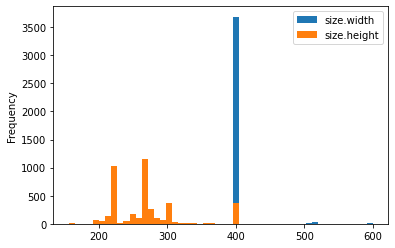

In [9]:
_ = full_dataset_annotations[['size.width', 'size.height']].plot.hist(bins = 50)

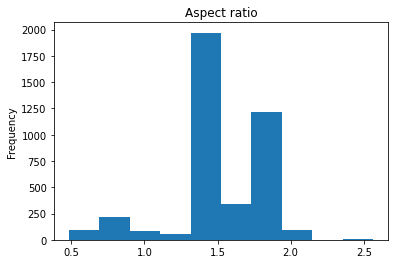

In [10]:
_ = (full_dataset_annotations['size.width']/full_dataset_annotations['size.height']).plot.hist()
_ = plt.title("Aspect ratio")

Text(0.5, 1.0, 'Distribution of labels')

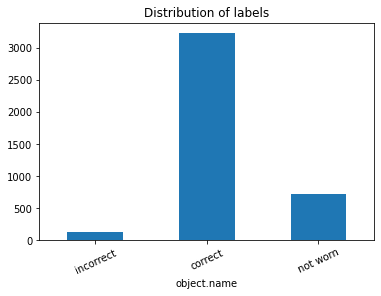

In [11]:
ax = full_dataset_annotations.groupby("object.name").size().plot.bar()
ax.set_xticklabels(["incorrect", "correct", "not worn"])
ax.tick_params(axis = 'x', labelrotation = 25)
plt.title("Distribution of labels")

Text(0.5, 1.0, 'Mean number of objects in an image\nper class')

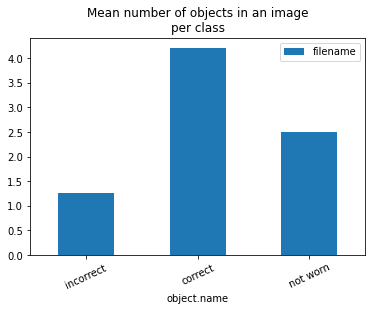

In [12]:
ax = full_dataset_annotations.groupby("object.name").agg({"filename": (lambda x: np.unique(x, return_counts = True)[1].mean())}).plot.bar()
ax.set_xticklabels(["incorrect", "correct", "not worn"])
ax.tick_params(axis = 'x', labelrotation = 25)
plt.title("Mean number of objects in an image\nper class")

Bbox annotation format: PascalVOC: xmin, ymin, xmax, ymax

## Build Dataset

In [13]:
full_dataset_annotations.loc[:, 'VOCbbox'] = full_dataset_annotations[['object.bndbox.xmin',
                                                                       "object.bndbox.ymin",
                                                                       "object.bndbox.xmax",
                                                                       "object.bndbox.ymax"]].apply(lambda x: list(x), axis = 1)

In [14]:
label_encoding = {"with_mask":1, "without_mask":2, "mask_weared_incorrect":3}

In [15]:
inv_encoding = {v:k for k,v in label_encoding.items()}

In [16]:
full_dataset_annotations.loc[:, "encoded_label"] = full_dataset_annotations["object.name"].replace(label_encoding)

In [17]:
dataset = full_dataset_annotations.groupby('filename')\
                .agg({"VOCbbox":list, "object.name": list, "encoded_label": list})\
                .rename(columns = {"object.name": "label"}).reset_index()

In [18]:
dataset.loc[:, 'filename'] = dataset['filename'].apply(lambda x: os.path.join(images_path, x))

In [19]:
incorrect = dataset.label.apply(lambda x: "mask_weared_incorrect" in x)
without = dataset.label.apply(lambda x: "without_mask" in x)

In [20]:
stratify_label = pd.Series(["with_mask"]*len(without), index = dataset.index)
stratify_label[incorrect] = "mask_weared_incorrect" 
stratify_label[(without)&(~incorrect)] = "without_mask"

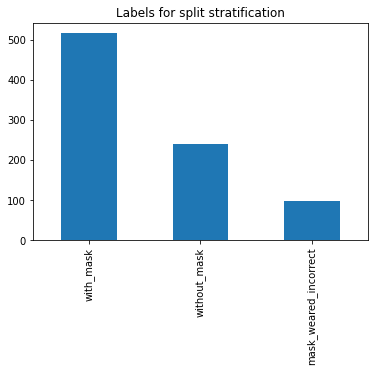

In [21]:
_ = stratify_label.value_counts().plot.bar()
_ = plt.title("Labels for split stratification")

In [22]:
dataset=dataset.drop(columns=['label'])

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
dataset_train, dataset_test = train_test_split(dataset, random_state = 42, test_size = 0.2, stratify=stratify_label)

In [25]:
dataset_train.VOCbbox.iloc[0]

[[49, 157, 144, 225], [151, 67, 270, 198]]

## Model training

In [26]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms


In [27]:
from torchvision.transforms import Compose, ToTensor

In [28]:
from utils import draw_basic_bbox

In [29]:
from dataset import FaceMaskVOCDataset

In [30]:
ds = FaceMaskVOCDataset(dataset_train, 320, 320, cache = True, training=True)
ds_test = FaceMaskVOCDataset(dataset_test, 320, 320, training=False, cache = True)

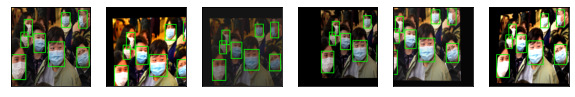

In [31]:
ds.training = False
fig = plt.figure(figsize = (10,5))
ax = fig.subplots(1,6)
img, targets = ds[5]
bboxes = targets['boxes'].numpy().astype(int)
img = img.permute(1,2,0).numpy()
ax[0].imshow(draw_basic_bbox(img, bboxes))
ax[0].get_yaxis().set_visible(False)
ax[0].get_xaxis().set_visible(False)

ds.training = True
for i in range(1,6):
    img, targets = ds[5]
    bboxes = targets['boxes'].numpy().astype(int)
    img = img.permute(1,2,0).numpy()
    ax[i].imshow(draw_basic_bbox(img, bboxes))
    ax[i].get_yaxis().set_visible(False)
    ax[i].get_xaxis().set_visible(False)
#plt.imshow(draw_basic_bbox(i, torch.FloatTensor(bb).numpy().astype(int)))



In [32]:
data_loader_train = torch.utils.data.DataLoader(
    ds, batch_size=8, shuffle=False, num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))) # output: ((images), (targets))

In [33]:
data_loader_test = torch.utils.data.DataLoader(
    ds_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))) # output: ((images), (targets))

# Train

In [34]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from utils import linear_learning_rate_warmup, linear_warmup_factor_wrapper
from tqdm.notebook import tqdm

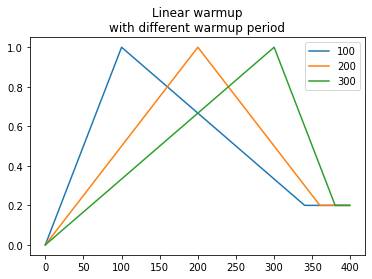

In [35]:
f = linear_warmup_factor_wrapper(100, 400, min_factor=0.2)
plt.plot([f(i) for i in range(400)], label='100')
f = linear_warmup_factor_wrapper(200, 400, min_factor=0.2)
plt.plot([f(i) for i in range(400)], label='200')
f = linear_warmup_factor_wrapper(300, 400, min_factor=0.2)
plt.plot([f(i) for i in range(400)], label='300')
plt.legend()
_ = plt.title("Linear warmup\nwith different warmup period")

In [36]:
model = fasterrcnn_resnet50_fpn(weights='COCO_V1')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes = 3+1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [37]:
# from types import MethodType

# from custom_forward_functions import forward_rcnn, forward_roi_heads

# model.forward = MethodType(forward_rcnn, model)
# model.roi_heads.forward = MethodType(forward_roi_heads, model.roi_heads)

In [38]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import gc

In [40]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

epochs = 10
model.to(device)
#optimizer = AdamW(model.parameters(), lr = lr)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr = 0.001, momentum = 0.9, weight_decay = 0.0001)

num_batches = len(data_loader_train)

# lr_scheduler = linear_learning_rate_warmup(optimizer,
#                                            int(0.3*num_batches*epochs), 
#                                            num_batches*epochs,
#                                            min_factor = 0.2)
train_losses = []
test_losses = []
mAP = []
for epoch in range(1, epochs+1):
    model.train()
    epoch_loss_train = 0
    epoch_loss_test = 0
    mAP_ = 0
    pbar = enumerate(data_loader_train)
    print("EPOCH: ", epoch)

    pbar = tqdm(pbar, total=num_batches, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
    
    optimizer.zero_grad()
    
    model.train()
    for i, (imgs, annotations) in pbar:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        #loss_dict, preds = model(imgs, annotations)
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        
        #print(losses)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #lr_scheduler.step()
        train_losses.append(losses.item())
        epoch_loss_train += losses.item()
    print('Epoch_loss = ',epoch_loss_train/(len(data_loader_train)*4))
    
    del imgs
    del annotations

    pbar = enumerate(data_loader_test)
    print("EPOCH: ", epoch)
    model.eval()
    pbar = enumerate(data_loader_test)
    pbar = tqdm(pbar, total=len(data_loader_test), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
    
    for i, (imgs, annotations) in pbar:
        mean_AP = MeanAveragePrecision()
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        #loss_dict, preds  = model(imgs, annotations)
        preds  = model(imgs, annotations)
        # losses = sum(loss for loss in loss_dict.values())        
        # test_losses.append(losses.item())
        # epoch_loss_test += losses.item()

        mean_AP.update([{k: v.to("cpu").detach() for k, v in t.items()} for t in preds],
                       [{k: v.to("cpu").detach() for k, v in t.items()} for t in annotations])
        current_map = mean_AP.compute()['map'].item()
        mAP_+= current_map
        mAP.append(current_map)
        del mean_AP

    print('Epoch_loss = ',epoch_loss_test/len(data_loader_test))
    print('Epoch_mAP = ', mAP_/len(data_loader_test))

    gc.collect()
    if epoch%5==0:
        torch.save(model.state_dict(), f"trained_model_{epoch}.ckpt")      

EPOCH:  1


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch_loss =  0.15629470318036023
EPOCH:  1


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch_loss =  0.0
Epoch_mAP =  0.4373084628758462
EPOCH:  2


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch_loss =  0.1252576805391284
EPOCH:  2


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch_loss =  0.0
Epoch_mAP =  0.5176760476213276
EPOCH:  3


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch_loss =  0.11167915689564029
EPOCH:  3


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch_loss =  0.0
Epoch_mAP =  0.5579083742279756
EPOCH:  4


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch_loss =  0.10428821754663489
EPOCH:  4


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch_loss =  0.0
Epoch_mAP =  0.5679262523588381
EPOCH:  5


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch_loss =  0.10072728224791759
EPOCH:  5


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch_loss =  0.0
Epoch_mAP =  0.6031683552683446
EPOCH:  6


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch_loss =  0.0933501927268713
EPOCH:  6


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch_loss =  0.0
Epoch_mAP =  0.5944988511459172
EPOCH:  7


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch_loss =  0.08869275199465973
EPOCH:  7


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch_loss =  0.0
Epoch_mAP =  0.60577815542357
EPOCH:  8


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch_loss =  0.08475265008678963
EPOCH:  8


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch_loss =  0.0
Epoch_mAP =  0.6216578155058866
EPOCH:  9


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch_loss =  0.08333894818328148
EPOCH:  9


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch_loss =  0.0
Epoch_mAP =  0.6108460635033964
EPOCH:  10


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch_loss =  0.08001191979057568
EPOCH:  10


  0%|          | 0/171 [00:00<?, ?it/s]

Epoch_loss =  0.0
Epoch_mAP =  0.6349098760830728


Text(0.5, 1.0, 'Moving avg of mAP scores')

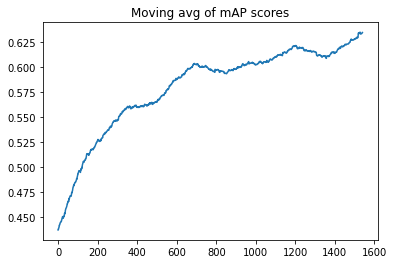

In [52]:
plt.plot(np.convolve(np.array(mAP), np.ones(171)/171, mode='valid'))
plt.title("Moving avg of mAP scores")

# Eval

In [45]:
model = model.eval()

In [76]:
imgs = []
for i in range(10):
  imgs.append(ds_test[i][0].to('cuda'))

In [75]:
del preds
gc.collect()

88

In [77]:
preds = model(imgs)

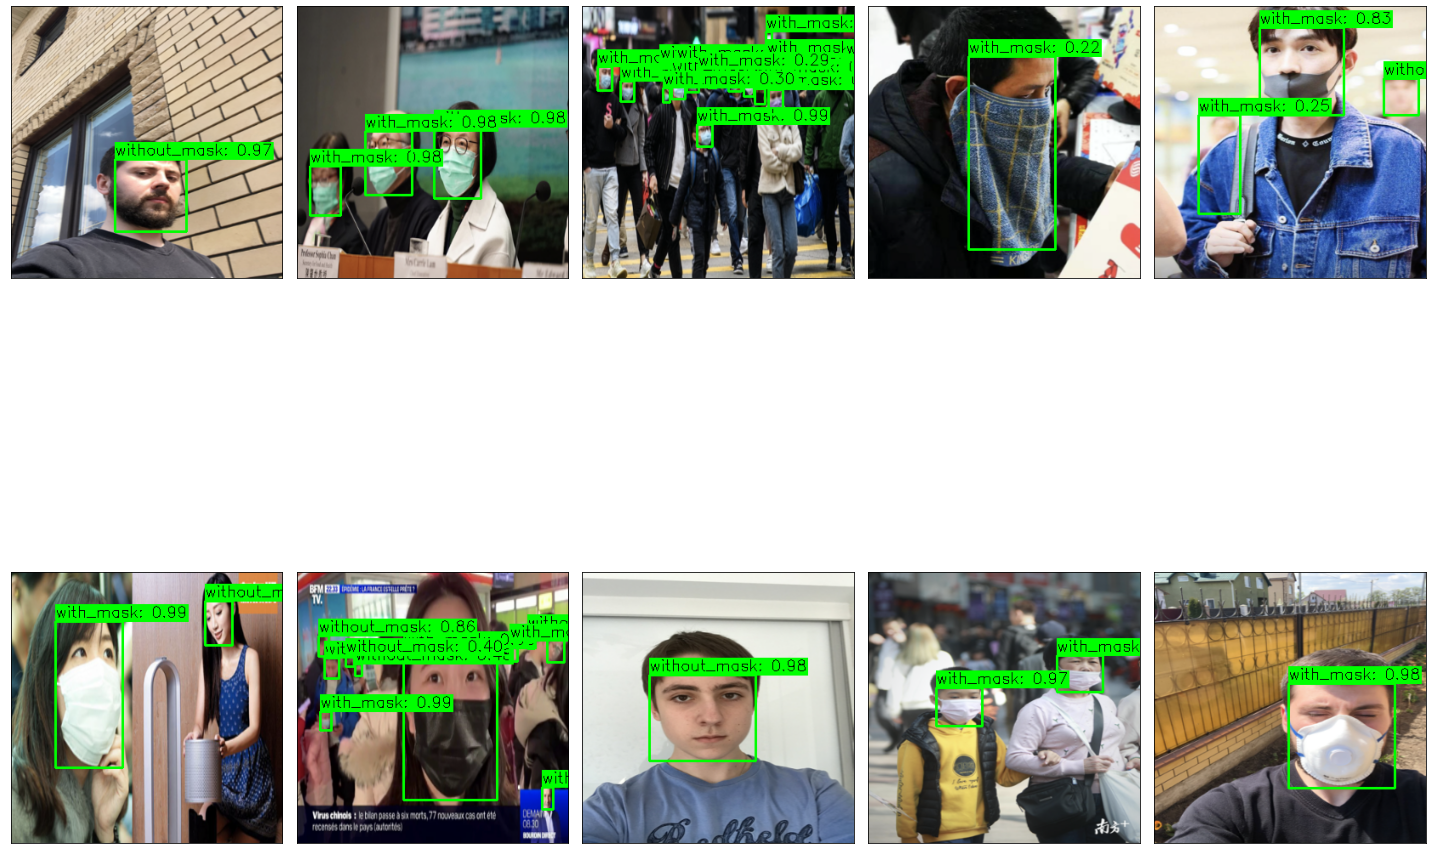

In [83]:
fig = plt.figure(figsize = (20,20))
ax = fig.subplots(2, 5)
for i, (img, pred) in enumerate(zip(imgs, preds)):
    bboxes, labels, scores = non_max_suppression(pred, iou_threshold=0.05, obj_score_thresh=0.2)
    img = (img.permute(1,2,0).cpu().numpy()*255).astype(np.int32).copy()
    img = create_img_for_plotting(img, inv_encoding, bboxes, labels, scores)
    ax[i//5,i%5].get_yaxis().set_visible(False)
    ax[i//5,i%5].get_xaxis().set_visible(False)
    ax[i//5,i%5].imshow(img)
plt.tight_layout()